# 2 词性标注和实体识别结果可视化技术

**前置项目： TextMining-Cluster的聚类结果**

实验主要介绍两种可视化工具：词性标注结果可视化实现、实体识别结果可视化实现、地图动态可视化实现、词云图分析实现等。
本章实验难度分为中级和高级。
中级实验：词性标注结果可视化实验、实体识别结果可视化实验
高级实验：社交媒体文本挖掘词云图分析实验、新冠肺炎疫情地图动态可视化实验

## 实验目的

本章实验的主要目的是掌握社交媒体文本挖掘系统的可视化模块常用的一些方法，
即词性标注、实体识别、分析结果等的可视化。
掌握如何使用华为云ModelArts Notebook从OBS下载数据、执行Python代码，
掌握数据挖掘的一般可视化流程。

## 1.  词性标注和实体识别结果可视化实验

先重新编辑华为云相关代码：

In [1]:
BUCKET_NAME = 'askiksa'
UNIQUE_ID = '34520182201779'
OBS_BASE_PATH = BUCKET_NAME

### 初始化ModelArts SDK

**access_key**：下载的AK

**secret_key**：下载的SK

**project_id**：项目ID

**region_name**：创建桶对应的区域（一般选择'cn-north-4'）华北-北京4

下面给出样例代码

In [2]:
from modelarts.session import Session
session = Session(access_key='',
                  secret_key='',
                  project_id='	0b9f5a5c1d00f5e50f5ec01dbf9f9e20',
                  region_name='cn-north-4')

In [7]:
# 下载词性标注结果文件为后续实验做准备
session.download_data(bucket_path=OBS_BASE_PATH+'/Spy/results/dataContent.csv', path='./dataContent.csv')
# 下载实体识别结果文件为后续实验做准备
session.download_data(bucket_path=OBS_BASE_PATH+'/Spy/results/entity.txt', path='./entity.txt')
# 下载聚类结果文件为后续实验做准备
session.download_data(bucket_path=OBS_BASE_PATH+'/Spy/results/myDXYData.csv', path='./myDXYData.csv')

session.download_data(bucket_path=OBS_BASE_PATH+'/Spy/results/source_data.csv', path='./source_data.csv')

Successfully download file askiksa/Spy/results/dataContent.csv from OBS to local ./dataContent.csv
Successfully download file askiksa/Spy/results/entity.txt from OBS to local ./entity.txt
Successfully download file askiksa/Spy/results/myDXYData.csv from OBS to local ./myDXYData.csv
Successfully download file askiksa/Spy/results/source_data.csv from OBS to local ./source_data.csv


加载相关的库，对文件进行读取

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
covisData = pd.read_csv('results/dataContent.csv')
covisData

,dataContent,address,label
0,当前/t 的/uj 高频词/n 新型/b 冠状病毒/l 肺炎/n 字数/n 太/d 多/m ...,https://weibo.com/2349895445/IrV3Hjecy?refer_f...,2
1,新/a 冠/v 好/a 想/v 九头鸟/i 的/uj 饭菜/n 那么/r 好吃/v 刚/d ...,https://weibo.com/1401586242/IrUHO63pJ?refer_f...,2
2,猜谜语/v 打/v 知名/v 专家/n 二名/m 听/v 物理学家/n 讲/v 生物/n 于...,https://weibo.com/3001493527/IrPNdtwbj?refer_f...,2
3,刚刚/d 看到/v 新闻/n 作为/v 姐妹/n 城市/ns 匹兹堡/ns 将/d 援助/v...,https://weibo.com/1419248092/IrNx4zBuR?refer_f...,2
4,新冠/n 儿时/t 看/v 中华/nz 小/a 当家/n 埋/v 下/f 一颗/m 厨神/n...,https://weibo.com/7188718843/Is5kuiCQN?refer_f...,2
...,...,...,...
9741,健康/a 科普/nrt 疫情/n 期间/f 在/p 单位/n 食堂/n 就餐/v 有/v 哪...,https://weibo.com/3136823705/K6Z16sP05?refer_f...,2
9742,我国/r 又/d 一新/d 冠/n 疫苗/n 获批/v 紧急/a 使用/v 由/p 中国科学...,https://weibo.com/3136823705/K6YUr5on3?refer_f...,2
9743,接种/v 新冠/n 疫苗/n 和/c 接种/v 其他/r 疫苗/n 之间/f 需/v 间隔/...,https://weibo.com/3136823705/K6YSCt9FY?refer_f...,2
9744,慢/a 病/n 防控/vn 睡眠/v 不是/c 小事/n 健康/a 息息相关/i 北京/ns...,https://weibo.com/3136823705/K6YRQFjBx?refer_f...,2


### 词性标注

**步骤 1	 词性标注结果文件解析**

对读取的词性标注结果文件进行解析得到关键词数组和标注词性数组

In [61]:
data = covisData['dataContent'].values # 获取结果数据
identify = covisData.index.values# 获取数据的id
# print(data)
part_of_speech = [] # 用于保存关键词数组
pos_values = [] # 用于保存词性数组

for i in range(len(data)):
    part_of_speech_list = []
    pos_values_list = []   #对每一个遍历的data都分别的搭建一个列表
    word_list = data[i].split(' ') # 根据空格进行分割得到每个标注结果
    for word in word_list:
        pos_word = word.split('/') # 根据‘/’进行分割分别得到关键词和词性
        pos_values_list.append(pos_word[1])
        part_of_speech_list.append(pos_word)
#     print(part_of_speech)
    pos_values_list = list(set(pos_values_list))
#     print(pos_values)
    part_of_speech.append(part_of_speech_list)
    pos_values.append(pos_values_list)
    
    
with open("t.txt","w+",encoding='utf-8') as f:
    f.write(str(part_of_speech))
print(part_of_speech[:50]) # 打印前100个
print(pos_values[:50])

[[['当前', 't'], ['的', 'uj'], ['高频词', 'n'], ['新型', 'b'], ['冠状病毒', 'l'], ['肺炎', 'n'], ['字数', 'n'], ['太', 'd'], ['多', 'm'], ['建议', 'n'], ['沿袭', 'v'], ['非典', 'b'], ['称谓', 'v'], ['以', 'p'], ['新冠', 'n'], ['为', 'p'], ['简称', 'v'], ['例如', 'v'], ['抗击', 'vn'], ['新冠', 'n'], ['新冠', 'n'], ['确诊', 'v'], ['病人', 'n'], ['等', 'u']], [['新', 'a'], ['冠', 'v'], ['好', 'a'], ['想', 'v'], ['九头鸟', 'i'], ['的', 'uj'], ['饭菜', 'n'], ['那么', 'r'], ['好吃', 'v'], ['刚', 'd'], ['毕业', 'n'], ['的', 'uj'], ['时候', 'n'], ['正赶上', 'i'], ['中关村', 'ns'], ['有', 'v'], ['一家', 'm'], ['就', 'd'], ['去', 'v'], ['吃', 'v'], ['了', 'ul']], [['猜谜语', 'v'], ['打', 'v'], ['知名', 'v'], ['专家', 'n'], ['二名', 'm'], ['听', 'v'], ['物理学家', 'n'], ['讲', 'v'], ['生物', 'n'], ['于是', 'c'], ['有', 'v'], ['了', 'ul'], ['小麦', 'n'], ['万斤', 'm'], ['的', 'uj'], ['宏伟目标', 'l'], ['而且', 'c'], ['报纸', 'n'], ['上', 'f'], ['居然', 'd'], ['实现', 'v'], ['了听', 'v'], ['医学专家', 'n'], ['的', 'uj'], ['良心', 'a'], ['医嘱', 'n'], ['于是', 'c'], ['全国', 'n'], ['在', 'p'], ['封堵', 'v'], ['湖北', 'ns'], ['人', 'n']

上面的代码实现了词性的分割和处理技术，对列表的数据简单说明：

**[[['当前', 't'], ['的', 'uj'], ['高频词', 'n'], ['新型', 'b'], ['冠状病毒', 'l'], ['肺炎', 'n'], ['字数', 'n'], ['太', 'd'], ['多', 'm'], ['建议', 'n'], ['沿袭', 'v'], ['非典', 'b'], ['称谓', 'v'], ['以', 'p'], ['新冠', 'n'], ['为', 'p'], ['简称', 'v'], ['例如', 'v'], ['抗击', 'vn'], ['新冠', 'n'], ['新冠', 'n'], ['确诊', 'v'], ['病人', 'n'], ['等', 'u']], [['新', 'a'], ['冠', 'v'], ['好', 'a'], ['想', 'v'], ['九头鸟', 'i'], ['的', 'uj'], ['饭菜', 'n'], ['那么', 'r'], ['好吃', 'v'], ['刚', 'd'], ['毕业', 'n'], ['的', 'uj'], ['时候', 'n'], ['正赶上', 'i'], ['中关村', 'ns'], ['有', 'v'], ['一家', 'm'], ['就', 'd'], ['去', 'v'], ['吃', 'v']]]**

三层方括号，表示对每一段的数据进行处理，整个DataFrame的每一条字段都被做了词性的切割技术处理

对于词性的截取我们也采用了多层的中括号。

接下来我们对原始未词性划分的Data重新观察

In [62]:
source_data = pd.read_csv("results/source_data.csv")
source_data

,博主昵称,博主主页,微博认证,微博达人,微博内容,发布位置,发布时间,微博地址,微博来源,转发,评论,赞,lb
0,平安与洒脱,https://weibo.com/2349895445?refer_flag=100103...,NaN,NaN,当前的高频词新型冠状病毒肺炎字数太多建议沿袭非典称谓以新冠为简称例如抗击新冠新冠确诊病人等,NaN,2020年01月30日 21:14,https://weibo.com/2349895445/IrV3Hjecy?refer_f...,0,NaN,NaN,NaN,2
1,susi2012,https://weibo.com/1401586242?refer_flag=100103...,微博会员,NaN,新冠好想九头鸟的饭菜那么好吃刚毕业的时候正赶上中关村有一家就去吃了,NaN,2020年01月30日 20:20,https://weibo.com/1401586242/IrUHO63pJ?refer_f...,0,NaN,NaN,NaN,2
2,真正想家,https://weibo.com/3001493527?refer_flag=100103...,NaN,NaN,猜谜语打知名专家二名听物理学家讲生物于是有了小麦万斤的宏伟目标而且报纸上居然实现了听医学专家...,NaN,2020年01月30日 07:49,https://weibo.com/3001493527/IrPNdtwbj?refer_f...,0,NaN,NaN,NaN,2
3,有山有水有理想,https://weibo.com/1419248092?refer_flag=100103...,NaN,NaN,刚刚看到新闻作为姐妹城市匹兹堡将援助武汉的疫情防控同一个世界2019nCov新冠武汉加油2美...,美国·University of Pittsburgh,2020年01月30日 02:04,https://weibo.com/1419248092/IrNx4zBuR?refer_f...,0,NaN,NaN,NaN,2
4,-王苇杭-,https://weibo.com/7188718843?refer_flag=100103...,NaN,NaN,新冠儿时看中华小当家埋下一颗厨神梦奈何母亲一直未开放厨房印象中上一次下厨还是两三年前在欧访学...,NaN,2020年01月31日 23:22,https://weibo.com/7188718843/Is5kuiCQN?refer_f...,0,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9741,北京市大兴区青云店镇中心卫生院,https://weibo.com/3136823705?refer_flag=100103...,微博官方认证,NaN,健康科普疫情期间在单位食堂就餐有哪些注意事项北京同心抗疫为爱而行健康科普汇北京疾控提醒您北京...,NaN,03月20日 02:10,https://weibo.com/3136823705/K6Z16sP05?refer_f...,0,NaN,NaN,NaN,2
9742,北京市大兴区青云店镇中心卫生院,https://weibo.com/3136823705?refer_flag=100103...,微博官方认证,NaN,我国又一新冠疫苗获批紧急使用由中国科学院微生物研究所和安徽智飞龙科马生物制药有限公司联合研发...,NaN,03月20日 01:54,https://weibo.com/3136823705/K6YUr5on3?refer_f...,0,NaN,NaN,NaN,2
9743,北京市大兴区青云店镇中心卫生院,https://weibo.com/3136823705?refer_flag=100103...,微博官方认证,NaN,接种新冠疫苗和接种其他疫苗之间需间隔多久会不会出现不良反应专家权威回应北京同心抗疫为爱而行健...,NaN,03月20日 01:49,https://weibo.com/3136823705/K6YSCt9FY?refer_f...,0,NaN,NaN,NaN,2
9744,北京市大兴区青云店镇中心卫生院,https://weibo.com/3136823705?refer_flag=100103...,微博官方认证,NaN,慢病防控睡眠不是小事健康息息相关北京同心抗疫为爱而行健康科普汇北京疾控提醒您北京战疫新冠肺炎...,NaN,03月20日 01:48,https://weibo.com/3136823705/K6YRQFjBx?refer_f...,0,NaN,NaN,NaN,2


根据id取出原始数据集中的文本片段

In [63]:
textContent = [] # 存储所有的处理文本的一个列表
for item in range(len(identify)):
    lines = source_data[source_data.index.values==identify[item]]
    lines = lines['微博内容'].values
    textContent.append(lines)
textContent[:100]

[array(['当前的高频词新型冠状病毒肺炎字数太多建议沿袭非典称谓以新冠为简称例如抗击新冠新冠确诊病人等'], dtype=object),
 array(['新冠好想九头鸟的饭菜那么好吃刚毕业的时候正赶上中关村有一家就去吃了'], dtype=object),
 array(['猜谜语打知名专家二名听物理学家讲生物于是有了小麦万斤的宏伟目标而且报纸上居然实现了听医学专家的良心医嘱于是全国在封堵湖北人勿庸置疑未来的而报纸上肯定又会说成功了亩产万斤微博辟谣新冠武汉封城L真正想家的微博视频'],
       dtype=object),
 array(['刚刚看到新闻作为姐妹城市匹兹堡将援助武汉的疫情防控同一个世界2019nCov新冠武汉加油2美国UniversityofPittsburgh'],
       dtype=object),
 array(['新冠儿时看中华小当家埋下一颗厨神梦奈何母亲一直未开放厨房印象中上一次下厨还是两三年前在欧访学后来嫌麻烦也嫌自己便成了带米带食材的各种蹭饭这个春节是读大学十年以来宅家最久的一次足不出户不妨学点生存技能今日小试菜刀照猫画虎收获光盘鼓励是为记'],
       dtype=object),
 array(['新冠两个晚上没有睡好一直反反复复在回想事情发生的状况从大年三十开始上班觉得疫情还能接受到现在去上班的路上就紧张在上班就更焦虑下班回家不敢回家不吃饭也不觉得饿整天就是洗手洗手喷消毒水没有做好分诊和潜伏期的原因确诊的第一例让五个同事隔离了到家就是哭害怕真的就是害怕每一天每个小时都在关注确诊人数死亡人数治愈人数还再脑补各种假设好的坏的都假设主任每天不断的开会群里的文件一条接一条恳请一线的同胞们保护好自己大家都要平安健康站了两天窗口除了把自己包裹的严严实实其他也做不了帽子口罩N95外科护目镜隔离衣白大褂两层手套白裤子还有今天才到货的鞋套物质匮乏只有这样了做可疑标本也只能这样了防止气溶胶污染甚至憋着气做酒精消毒水就在手上喷恨不得泡个84澡不知道被酒精呛了多少次不知道每天洗手多少次不知道每天收到多少信息询问疫情情况亲朋好友们我的压力也很大你们听来的乱七八糟的消息自己慢慢理解我只能告诉你们别乱跑好好在家呆着好好保护自己千万保重致敬在一线的所有同胞大家一起加油大家一起平安收起全文d'],
       dtype=objec

In [64]:
Content = textContent

可以看到每一个都被添加到textContent列表中去了

**步骤 2	文本片段关键词词性标注可视化显示**

我们将文本片段中对应的关键词进行词性标注和可视化显示在输出结果中。
控制台输出带颜色文字的方法参考如下说明：

In [65]:
speech_list = part_of_speech[:150]
for keyword in range(len(speech_list)):
    if keyword <=5:
        print(speech_list[keyword]) # keyword 每个的字段
    
    for detailed_kwd in range(len(speech_list[keyword])):
        word = speech_list[keyword][detailed_kwd][0]
        pos = speech_list[keyword][detailed_kwd][1]

        if pos == 'a':
            new_word = '\033[43m' + word + '\033[0m' # yellow background
#             print("Content[1]=", Content[1][0])
            len_w = len(word)
            len_t = len(Content[keyword][0])
#             print(new_word)
#             print(len_w, len_t)
            for i in range(len_t - len_w, -1, -1):
#                 print(Content[1][detailed_kwd], Content[1][detailed_kwd][i: i + len_w])
#                 print(word)
                
                if Content[keyword][0][i: i + len_w] == word:
#                     print("word = ", word)
                    Content[keyword][0] = Content[keyword][0][:i] + new_word + Content[keyword][0][i + len_w:]
#             print(Content[1][0])
        elif pos == 'v':
            new_word = '\033[42m' + word + '\033[0m' # red background
#             print("Content[1]=", Content[1][0])
            len_w = len(word)
            len_t = len(Content[keyword][0])
            for i in range(len_t - len_w, -1, -1):
#                 print(Content[1][detailed_kwd], Content[1][detailed_kwd][i: i + len_w])
#                 print(word)
                
                if Content[keyword][0][i: i + len_w] == word:

                    Content[keyword][0] = Content[keyword][0][:i] + new_word + Content[keyword][0][i + len_w:]

        elif pos =='n':
            new_word = '\033[41m' + word + '\033[0m' # red background

            len_w = len(word)
            len_t = len(Content[keyword][0])
            for i in range(len_t - len_w, -1, -1):
                if Content[keyword][0][i: i + len_w] == word:
                    Content[keyword][0] = Content[keyword][0][:i] + new_word + Content[keyword][0][i + len_w:]
    if keyword <=5:
        print(Content[keyword][0])


[['当前', 't'], ['的', 'uj'], ['高频词', 'n'], ['新型', 'b'], ['冠状病毒', 'l'], ['肺炎', 'n'], ['字数', 'n'], ['太', 'd'], ['多', 'm'], ['建议', 'n'], ['沿袭', 'v'], ['非典', 'b'], ['称谓', 'v'], ['以', 'p'], ['新冠', 'n'], ['为', 'p'], ['简称', 'v'], ['例如', 'v'], ['抗击', 'vn'], ['新冠', 'n'], ['新冠', 'n'], ['确诊', 'v'], ['病人', 'n'], ['等', 'u']]
当前的高频词新型冠状病毒肺炎字数太多建议沿袭非典称谓以新冠为简称例如抗击新冠新冠确诊病人等
[['新', 'a'], ['冠', 'v'], ['好', 'a'], ['想', 'v'], ['九头鸟', 'i'], ['的', 'uj'], ['饭菜', 'n'], ['那么', 'r'], ['好吃', 'v'], ['刚', 'd'], ['毕业', 'n'], ['的', 'uj'], ['时候', 'n'], ['正赶上', 'i'], ['中关村', 'ns'], ['有', 'v'], ['一家', 'm'], ['就', 'd'], ['去', 'v'], ['吃', 'v'], ['了', 'ul']]
新冠好想九头鸟的饭菜那么好吃刚毕业的时候正赶上中关村有一家就去吃了
[['猜谜语', 'v'], ['打', 'v'], ['知名', 'v'], ['专家', 'n'], ['二名', 'm'], ['听', 'v'], ['物理学家', 'n'], ['讲', 'v'], ['生物', 'n'], ['于是', 'c'], ['有', 'v'], ['了', 'ul'], ['小麦', 'n'], ['万斤', 'm'], ['的', 'uj'], ['宏伟目标', 'l'], ['而且', 'c'], ['报纸', 'n'], ['上', 'f'], ['居然', 'd'], ['实现', 'v'], ['了听', 'v'], ['医学专家', 'n'], ['的', 'uj'], ['良心', 'a'], ['医嘱', 'n']

In [66]:
for keyword in range(100):
    print(Content[keyword][0],end="\n\n")

当前的高频词新型冠状病毒肺炎字数太多建议沿袭非典称谓以新冠为简称例如抗击新冠新冠确诊病人等

新冠好想九头鸟的饭菜那么好吃刚毕业的时候正赶上中关村有一家就去吃了

猜谜语打知名专家二名听物理学家讲生物于是有了小麦万斤的宏伟目标而且报纸上居然实现了听医学专家的良心医嘱于是全国在封堵湖北人勿庸置疑未来的而报纸上肯定又会说成功了亩产万斤微博辟谣新冠武汉封城L真正想家的微博视频

刚刚看到新闻作为姐妹城市匹兹堡将援助武汉的疫情防控同一个世界2019nCov新冠武汉加油2美国UniversityofPittsburgh

新冠儿时看中华小当家埋下一颗厨神梦奈何母亲一直未开放厨房印象中上一次下厨还是两三年前在欧访学后来嫌麻烦也嫌自己便成了带米带食材的各种蹭饭这个春节是读大学十年以来宅家最久的一次足不出户不妨学点生存技能今日小试菜刀照猫画虎收获光盘鼓励是为记

新冠两个晚上没有睡好一直反反复复在回想事情发生的状况从大年三十开始上班觉得疫情还能接受到现在去上班的路上就紧张在上班就更焦虑下班回家不敢回家不吃饭也不觉得饿整天就是洗手洗手喷消毒水没有做好分诊和潜伏期的原因确诊的第一例让五个同事隔离了到家就是哭害怕真的就是害怕每一天每个小时都在关注确诊人数死亡人数治愈人数还再脑补各种假设好的坏的都假设主任每天不断的开会群里的文件一条接一条恳请一线的同胞们保护好自己大家都要平安健康站了两天窗口除了把自己包裹的严严实实其他也做不了帽子口罩N95外科护目镜隔离衣白大褂两层手套白裤子还有今天才到货的鞋套物质匮乏只有这样了做可疑标本也只能这样了防止气溶胶污染甚至憋着气做酒精消毒水就在手上喷恨不得泡个84澡不知道被酒精呛了多少次不知道每天洗手多少次不知道每天收到多少信息询问疫情情况亲朋好友们我的压力也很大你们听来的乱七八糟的消息自己慢慢理解我只能告诉你们别乱跑好好在家呆着好好保护自己千万保重致敬在一线的所有同胞大家一起加油大家一起平安收起全文d

新冠突然宣布科室成为本院隔离病房然后我们就开始了从早忙到晚的节奏好在大家一条心虽然物资不足到大家没放弃依然在前行08年汶川地震发生时刚好大一下期跟好朋友约着想去当自愿者因为种种原因未能达成目标心理始终有着遗憾这一次新冠疫情虽然没有在疫情一线但好歹在护理一线也算加入这次抗击疫情的队伍中吧相信很快就会战胜疫情也相信同行们能够凯旋我们都很美收起全文d

这个时期的

上面的代码，我们可以看到处理过的数据，显示出的形容词、名词、动词的颜色加深变化，虽然一些识别的效果不是很好，
但是还是看到相关的明显显示： 形容词是黄色，动词是绿色，名词是红色

## 实体识别技术

说明：这里的实体集也是上一节课留下来的，但是之前留下来的是txt格式文本，处理起来和单纯csv格式不一样

截取的是对应的前250条数据。

下面尝试对文本进行分割处理，变成可以元素操作的列表。

In [67]:
with open("results/entity.txt",'r',encoding="utf-8") as f:
    res = f.readlines()

whole_list = []
for item in res:
    a = item[1:-2].split(", ")
    n_list = []
    for i in a:
        n_list.append(i[1:-1])
    whole_list.append(n_list)
whole_list

[['新冠', '高频词', '肺炎', '字数', '病人', '建议'],
 ['中关村', '饭菜', '毕业', '时候'],
 ['报纸', '新冠', '医学专家', '想家', '医嘱', '视频', '物理学家', '武汉', '湖北', '小麦'],
 ['武汉', '新冠', '匹兹堡', '疫情', '姐妹', '新闻', '城市', '世界', '美国'],
 ['厨神', '小试', '新冠', '食材', '宅家', '菜刀', '光盘', '当家', '技能', '厨房'],
 ['消毒水', '人数', '酒精', '疫情', '大家', '回家', '护目镜', '新冠', '鞋套', '同胞们'],
 ['疫情', '新冠', '自愿者', '隔离病房', '本院', '科室', '大家', '汶川', '种种原因', '护理'],
 ['新冠', '日子', '时期'],
 ['新冠', '颗粒物', '效率', '意思', '标准', '美国', '中国'],
 ['人心', '新冠', '鬼神'],
 ['新冠', '黑死病', '人类', '战争', '杰出人物', '温饱', '飞速', '通史', '共同体', '朝代'],
 ['新冠', '口罩', '手套', '时刻', '妈妈'],
 ['体温计', '新冠'],
 ['病院', '神山', '火神', '肺炎', '武漢', '機能', '現場', '新冠', '频道', '全文'],
 ['新冠', '口罩', '用途'],
 ['奶茶', '回家'],
 ['新冠', '都宅', '两本书', '生活用品', '全家', '病毒', '原本', '办公室', '回家', '业务'],
 ['新冠', '共克', '疫区', '时艰', '莆田', '疫情', '定义', '全面'],
 ['字节', '祖国', '宅家', '听友', '新冠', '事件', '限时', '公共卫生', '全文', '疫情'],
 ['新冠', '数字', '家庭', '北京', '国家'],
 ['腦炎', '肺炎', '朋友圈', '單詞', '疫區', '國疫區', '夜店', '心態', '球賽', '領導'],
 ['现原形', '新冠', '禽流感', '国难'

In [93]:
listA = whole_list[40]
print(listA)


myContent = [] # 存储所有的处理文本的一个列表
for item in range(len(identify)):
    lines = source_data[source_data.index.values==identify[item]]
    lines = lines['微博内容'].values
    myContent.append(lines)

print(myContent[40][0])
for item in listA:
    new_word = '\033[45m' + item + '\033[0m' # yellow background
    len_w = len(item)
    len_t = len(myContent[40][0])
    for i in range(len_t - len_w, -1, -1):
#         print(myContent[40][0][i: i + len_w])
        if myContent[40][0][i: i + len_w] == item:
            myContent[40][0] = myContent[40][0][:i] + new_word + myContent[40][0][i + len_w:]
print(myContent[40][0])

['新宁', '新冠', '医院', '感染者', '出院', '顶级', '好消息', '加拿大', '地区']
好消息多伦多第一例确诊感染者已经从多伦多国立新宁医院SunnybrookHospital康复出院新宁不亏是多伦多地区的顶级医院新冠治愈加拿大
好消息多伦多第一例确诊感染者已经从多伦多国立新宁医院SunnybrookHospital康复出院新宁不亏是多伦多地区的顶级医院新冠治愈加拿大


部分内容和上图类似，因此我们直接选择随机的一条测试即可,可以看到生成了相关颜色的实体情况。
上述代码也可以用去遍历操作生成批量的实体颜色标记结果。

#  社交媒体文本挖掘词云图分析实验

目的： 通过实践，掌握词云图分析的基本流程，并结合实践操作加深对可视化工具的理解和应用。

文本导入：

In [51]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import jieba.analyse

这一步准备实验所需的数据，相关资源在已上传并保存在OBS中，我们通过ModelArts SDK将资源下载到本地。

In [9]:
# 下载聚类结果文件为后续实验做准备
session.download_data(bucket_path=OBS_BASE_PATH+'/Spy/results/source_data.csv', path='./source_data.csv')

Successfully download file askiksa/Spy/results/source_data.csv from OBS to local ./source_data.csv


In [48]:
# 数据读取
df_cluster = pd.read_csv(r"results/source_data.csv",encoding="utf-8")
df_cluster.head()

,博主昵称,博主主页,微博认证,微博达人,微博内容,发布位置,发布时间,微博地址,微博来源,转发,评论,赞,lb
0,平安与洒脱,https://weibo.com/2349895445?refer_flag=100103...,NaN,NaN,当前的高频词新型冠状病毒肺炎字数太多建议沿袭非典称谓以新冠为简称例如抗击新冠新冠确诊病人等,NaN,2020年01月30日 21:14,https://weibo.com/2349895445/IrV3Hjecy?refer_f...,0,NaN,NaN,NaN,2
1,susi2012,https://weibo.com/1401586242?refer_flag=100103...,微博会员,NaN,新冠好想九头鸟的饭菜那么好吃刚毕业的时候正赶上中关村有一家就去吃了,NaN,2020年01月30日 20:20,https://weibo.com/1401586242/IrUHO63pJ?refer_f...,0,NaN,NaN,NaN,2
2,真正想家,https://weibo.com/3001493527?refer_flag=100103...,NaN,NaN,猜谜语打知名专家二名听物理学家讲生物于是有了小麦万斤的宏伟目标而且报纸上居然实现了听医学专家...,NaN,2020年01月30日 07:49,https://weibo.com/3001493527/IrPNdtwbj?refer_f...,0,NaN,NaN,NaN,2
3,有山有水有理想,https://weibo.com/1419248092?refer_flag=100103...,NaN,NaN,刚刚看到新闻作为姐妹城市匹兹堡将援助武汉的疫情防控同一个世界2019nCov新冠武汉加油2美...,美国·University of Pittsburgh,2020年01月30日 02:04,https://weibo.com/1419248092/IrNx4zBuR?refer_f...,0,NaN,NaN,NaN,2
4,-王苇杭-,https://weibo.com/7188718843?refer_flag=100103...,NaN,NaN,新冠儿时看中华小当家埋下一颗厨神梦奈何母亲一直未开放厨房印象中上一次下厨还是两三年前在欧访学...,NaN,2020年01月31日 23:22,https://weibo.com/7188718843/Is5kuiCQN?refer_f...,0,NaN,NaN,NaN,2


**聚类结果词云图分析**

{'新冠': 1.0, '疫情': 0.5764673118820056, '美国': 0.3569540899936653, '肺炎': 0.2534750910673004, '疫苗': 0.1990209761209092, '病毒': 0.18864523341009828, '北京': 0.17308735318323193, '全文': 0.15232223430418215, '新闻': 0.1230454651677356, '中国': 0.10802336168003172, '全球': 0.10528357018283487, '英国': 0.07594757875555487, '视频': 0.07511166648017469, '人权': 0.07495136033626014, '医院': 0.06843212148135595, '口罩': 0.05990454992569798, '国家': 0.05848842686273721, '病例': 0.05622967221788147, '日本': 0.050383725181709325, '部分': 0.04951447426366372, '医疗': 0.04899916975124695, '链接': 0.04856822769985014, '网页': 0.04602804721363981, '韩国': 0.04557863473035636, '示威者': 0.044834802667494435, '患者': 0.042185695273857474, '北京市': 0.04077433666368578, '武汉': 0.03855057339044821, '太原市': 0.03737378352969195, '小区': 0.036893516791530336, '法国': 0.036504390731117047, '核酸': 0.03507473965495214, '国际': 0.034723140559367906, '上海': 0.033796433678759015, '全国': 0.03365918671420665, '香港': 0.03331711659158877, '大家': 0.0325978577748113, '人员': 0.0313

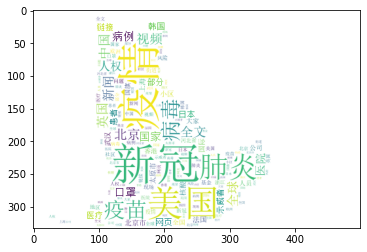

In [55]:
# 以cluster=1的聚类结果为例
cluster1 = df_cluster[df_cluster['lb']==2]
cluster1 = ' '.join(cluster1['微博内容'].values)

# 提取cluster 1的主题关键词
kw1 = jieba.analyse.textrank(cluster1,topK=50,withWeight=True,allowPOS=('ns','n'))
words_frequence = {x[0]:x[1] for x in kw1}
print(words_frequence)
backgroud_Image=plt.imread('data/cat.jpg') # 准备背景样式
# 若是有中文的话，font_path ='simsun.ttc'必须添加，不然会出现方框，不出现汉字
# simsun.ttc为汉字编码文件，可以从本地windows系统找一个汉字编码文件上传， 如C:\\Windows\Fonts下有许多汉字编码文件
wordcloud = WordCloud(font_path ='data/simsun.ttc',mask=backgroud_Image,repeat=True,background_color='white')
wordcloud = wordcloud.fit_words(words_frequence)
plt.imshow(wordcloud)
plt.show()

下面对聚类结果主题为疫苗观察分析

{'疫苗': 1.0, '新冠': 0.33827107457187644, '疫情': 0.15444756967505546, '美国': 0.10577350091314425, '病毒': 0.10504280575061, '中国': 0.09776637917380916, '全文': 0.09233938702403173, '肺炎': 0.07152966145397449, '国家': 0.06409343447116848, '视频': 0.06160106607237866, '医院': 0.05665630626373732, '香港': 0.049171153907981574, '英国': 0.04690073943209047, '医疗': 0.04394765402960786, '核酸': 0.03746748781804223, '口罩': 0.03595930538375255, '北京': 0.03564914473818484, '日本': 0.03548419522742182, '全球': 0.03505228564579625, '链接': 0.03132816968053027, '太原市': 0.031229829275549424, '基金': 0.030007930772644006, '网页': 0.029963871020581345, '创业板': 0.025850013682199476, '患者': 0.025459007171919703, '问题': 0.02518999890015259, '计划': 0.02407655810067374, '阿斯利康': 0.023855518602982708, 'A股': 0.02354782931476407, '新闻': 0.022995486389737706, '人群': 0.022619399475520316, '公司': 0.022563731331737915, '山西': 0.02109055925261904, '科兴': 0.020536495845714334, '医生': 0.020460400074428783, '责任': 0.019380251316156134, '变异': 0.018270939036294495, '

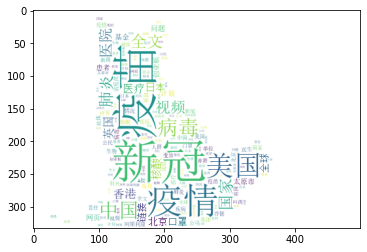

In [56]:
# 以cluster=1的聚类结果为例
cluster1 = df_cluster[df_cluster['lb']==1]
cluster1 = ' '.join(cluster1['微博内容'].values)

# 提取cluster 1的主题关键词
kw1 = jieba.analyse.textrank(cluster1,topK=50,withWeight=True,allowPOS=('ns','n'))
words_frequence = {x[0]:x[1] for x in kw1}
print(words_frequence)
backgroud_Image=plt.imread('data/cat.jpg') # 准备背景样式
# 若是有中文的话，font_path ='simsun.ttc'必须添加，不然会出现方框，不出现汉字
# simsun.ttc为汉字编码文件，可以从本地windows系统找一个汉字编码文件上传， 如C:\\Windows\Fonts下有许多汉字编码文件
wordcloud = WordCloud(font_path ='data/simsun.ttc',mask=backgroud_Image,repeat=True,background_color='white')
wordcloud = wordcloud.fit_words(words_frequence)
plt.imshow(wordcloud)
plt.show()

请对比分析各个类别的主题有什么特点和区别？

# 新冠肺炎疫情地图动态可视化实验

本次实验使用的数据集来源于丁香园2019新型冠状病毒疫情数据的局部样本，目的是进行疫情程度分析且基于动态地图对疫情数据基于时间维度进行可视化。本实验随机抽取了121条福建省的样本作为示例。

数据集：(data/DXYdata.csv)

## 实践目的

通过实践，掌握数据分析结果可视化的基本流程，并结合实践操作加深对可视化工具的理解和应用

**步骤 1	导入相应的模块**
本实验使用pyecharts用于绘图。

In [12]:
!pip install pyecharts
#加载Python库
#加载绘图模块
from pyecharts import options as opts
from pyecharts.charts import Geo

    100% |████████████████████████████████| 143kB 24.3MB/s ta 0:00:01
    100% |████████████████████████████████| 133kB 24.8MB/s ta 0:00:01
    100% |████████████████████████████████| 133kB 15.3MB/s ta 0:00:01


数据读取

In [13]:
#数据读取
import pandas as pd
df_dxy = pd.read_csv(r"data/DXYdata.csv",encoding="gbk")
df_dxy.head()

,Date,Province,Confirmed
0,2020/1/22,福建,1
1,2020/1/23,福建,5
2,2020/1/24,福建,10
3,2020/1/25,福建,18
4,2020/1/26,福建,35


In [14]:
# 日期排序
df_dxy.sort_values(by="Date" , inplace=True, ascending=True)
df_dxy.head(50)

,Date,Province,Confirmed
0,2020/1/22,福建,1
121,2020/1/22,北京,14
1,2020/1/23,福建,5
122,2020/1/23,北京,22
2,2020/1/24,福建,10
123,2020/1/24,北京,36
3,2020/1/25,福建,18
124,2020/1/25,北京,41
4,2020/1/26,福建,35
125,2020/1/26,北京,68


In [15]:
# 以2020/2/17号为例画静态地图
# 可通过for循环实现每个日期地图的生成
Date1 = df_dxy[df_dxy['Date']=='2020/2/17']
province = list(Date1['Province'])
num = list(Date1['Confirmed'])
print(province)
print(num)

c = (
    Geo()
    .add_schema(maptype="china")   # 中国地图
    .add("疫情地图", [list(z) for z in zip(province, num)])
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
    .set_global_opts(
        visualmap_opts=opts.VisualMapOpts(),
        title_opts=opts.TitleOpts(title="疫情地图示例"),
    )
)

c.render(path="DXYMap.html")


['北京', '重庆', '福建']
[381, 553, 290]


'/home/ma-user/work/DXYMap.html'

生成相关的链接参考：[WebSpyder\DataVision\DXYMap.html](DXYMap.html)

下面我们尝试：
请实现地图动态显示疫情随时间的变化情况（参考博客：[https://zhuanlan.zhihu.com/p/127210461](https://zhuanlan.zhihu.com/p/127210461)）

第三方库： Timeline

In [16]:
from pyecharts.charts import Timeline
from pyecharts.globals import ThemeType
# 画整个日期的动态地图
# 可通过for循环实现每个日期地图的生成

timeline = Timeline(
        init_opts=opts.InitOpts(width="1600px", height="900px", theme=ThemeType.DARK)
)

for i in df_dxy['Date']:
    Date1 = df_dxy[df_dxy['Date']==i]
    province = list(Date1['Province'])
    num = list(Date1['Confirmed'])
    print(i)
    print(province)
    print(num)

    map0 = (
        Geo()
        .add_schema(maptype="china")   # 中国地图
        .add("疫情地图", [list(z) for z in zip(province, num)])
        .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
        .set_global_opts(
            visualmap_opts=opts.VisualMapOpts(),
            title_opts=opts.TitleOpts(title="疫情地图示例"),
        )
    )

    timeline.add(map0,str(i))


timeline.render(path="DXYDynamicMap.html")

2020/1/22
['福建', '北京']
[1, 14]
2020/1/22
['福建', '北京']
[1, 14]
2020/1/23
['福建', '北京']
[5, 22]
2020/1/23
['福建', '北京']
[5, 22]
2020/1/24
['福建', '北京']
[10, 36]
2020/1/24
['福建', '北京']
[10, 36]
2020/1/25
['福建', '北京']
[18, 41]
2020/1/25
['福建', '北京']
[18, 41]
2020/1/26
['福建', '北京']
[35, 68]
2020/1/26
['福建', '北京']
[35, 68]
2020/1/27
['福建', '北京']
[59, 80]
2020/1/27
['福建', '北京']
[59, 80]
2020/1/28
['福建', '北京']
[80, 91]
2020/1/28
['福建', '北京']
[80, 91]
2020/1/29
['福建', '北京']
[84, 111]
2020/1/29
['福建', '北京']
[84, 111]
2020/1/30
['北京', '福建']
[114, 101]
2020/1/30
['北京', '福建']
[114, 101]
2020/1/31
['福建', '北京']
[120, 139]
2020/1/31
['福建', '北京']
[120, 139]
2020/2/1
['重庆', '北京', '福建']
[247, 168, 144]
2020/2/1
['重庆', '北京', '福建']
[247, 168, 144]
2020/2/1
['重庆', '北京', '福建']
[247, 168, 144]
2020/2/10
['重庆', '福建', '北京']
[486, 261, 337]
2020/2/10
['重庆', '福建', '北京']
[486, 261, 337]
2020/2/10
['重庆', '福建', '北京']
[486, 261, 337]
2020/2/11
['福建', '重庆', '北京']
[267, 505, 342]
2020/2/11
['福建', '重庆', '北京']
[267, 505, 34

2020/5/15
['重庆', '福建', '北京']
[579, 356, 593]
2020/5/15
['重庆', '福建', '北京']
[579, 356, 593]
2020/5/15
['重庆', '福建', '北京']
[579, 356, 593]
2020/5/16
['北京', '重庆', '福建']
[593, 579, 356]
2020/5/16
['北京', '重庆', '福建']
[593, 579, 356]
2020/5/16
['北京', '重庆', '福建']
[593, 579, 356]
2020/5/17
['重庆', '北京', '福建']
[579, 593, 356]
2020/5/17
['重庆', '北京', '福建']
[579, 593, 356]
2020/5/17
['重庆', '北京', '福建']
[579, 593, 356]
2020/5/18
['重庆', '福建', '北京']
[579, 356, 593]
2020/5/18
['重庆', '福建', '北京']
[579, 356, 593]
2020/5/18
['重庆', '福建', '北京']
[579, 356, 593]
2020/5/19
['重庆', '北京', '福建']
[579, 593, 356]
2020/5/19
['重庆', '北京', '福建']
[579, 593, 356]
2020/5/19
['重庆', '北京', '福建']
[579, 593, 356]
2020/5/2
['重庆', '福建', '北京']
[579, 356, 593]
2020/5/2
['重庆', '福建', '北京']
[579, 356, 593]
2020/5/2
['重庆', '福建', '北京']
[579, 356, 593]
2020/5/20
['福建', '北京', '重庆']
[356, 593, 579]
2020/5/20
['福建', '北京', '重庆']
[356, 593, 579]
2020/5/20
['福建', '北京', '重庆']
[356, 593, 579]
2020/5/21
['北京', '福建', '重庆']
[593, 356, 579]
2020/5/21
['北

'/home/ma-user/work/DXYDynamicMap.html'

生成相关的链接参考：[WebSpyder\DataVision\DXYDynamicMap.html](DXYDynamicMap.html)

点击下面的播放键，可以看到随着日期变化疫情人数变化的数据，颜色变深等情况，呈现出随着时间变化颜色也变化的趋势，也可以手动拉滚动条观察变化的结果。